In [37]:

import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import grad

# Reproductibilité 
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device (GPU/CPU) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")


 Using device: cpu


## Fonction `generate_data` : Génération de données synthétiques

Cette fonction simule les dynamiques thermiques d'un système à trois températures (électrons, réseau cristallin, eau) sous l'effet d'une impulsion laser femtoseconde.

**Paramètres physiques :**
- `tau` : durée caractéristique de l'impulsion laser (ps)
- `fluence` : énergie par unité de surface (J/m²)
- `wavelength` : longueur d'onde du laser (m)
- `t_end` : durée totale de simulation (s)
- `steps_per_tau` : résolution temporelle (points par tau)

**Modèle physique simplifié :**
- **Température électronique (T_e)** : monte rapidement via une Gaussienne centrée à t₀ = 3τ, puis décroît exponentiellement
- **Température du réseau (T_l)** : augmente plus lentement (couplage électron-phonon), puis relaxe
- **Température de l'eau (T_w)** : augmentation monotone lente (dissipation thermique vers le milieu)

Cette approche évite de résoudre numériquement les équations différentielles du modèle à deux températures (TTM), tout en capturant les tendances physiques essentielles.

In [38]:
# In-notebook implementation of `generate_data` (replaces import from gen.py)
import numpy as np

def generate_data(tau=1e-11, fluence=300.0, wavelength=400e-9, t_end=60e-12, steps_per_tau=1600):
    """Generate synthetic high-density time/temperature data.
    Returns: time(s), T_e(K), T_l(K), T_w(K), sigma_abs(m^2)
    """
    # Time axis
    n_steps = int(max(2, np.ceil(steps_per_tau * (t_end / max(tau, 1e-30)))))
    time = np.linspace(0.0, float(t_end), n_steps, dtype=float)

    # Simple wavelength scaling for absorption cross-section (placeholder model)
    sigma_abs = 1e-20 * (400e-9 / max(wavelength, 1e-30))

    # Base temperature and pulse shape
    T0 = 300.0
    amp = 2000.0 * (fluence / 300.0) * (400e-9 / max(wavelength, 1e-30))
    t0 = 3.0 * tau
    pulse_sigma = 0.35 * tau
    g = np.exp(-0.5 * ((time - t0) / max(pulse_sigma, 1e-30)) ** 2)

    # Electron temperature: sharp rise with Gaussian pulse + fast decay tail
    tail = np.exp(-np.maximum(time - t0, 0.0) / max(2.5 * tau, 1e-30))
    T_e = T0 + amp * (g + 0.15 * tail)

    # Lattice temperature: slower rise and relaxation
    rise_l = 1.0 - np.exp(-time / max(2.5 * tau, 1e-30))
    relax_l = np.exp(-time / max(30.0 * tau, 1e-30))
    T_l = T0 + 0.35 * amp * rise_l * relax_l

    # Water temperature: slow monotonic rise
    T_w = T0 + 0.10 * amp * (1.0 - np.exp(-time / max(15.0 * tau, 1e-30)))

    # Numerical safety
    for arr in (T_e, T_l, T_w):
        np.nan_to_num(arr, copy=False)

    return time, T_e, T_l, T_w, float(sigma_abs)

### Remarques sur les paramètres choisis

Nous avons fixé :
- `tau = 1e-11 s` (10 ps) : ordre de grandeur typique pour les lasers femtosecondes
- `fluence = 300 J/m²` : fluence modérée évitant l'ablation
- `wavelength = 400 nm` : laser UV proche du seuil d'absorption pour de nombreux matériaux
- `t_end = 60 ps` : suffisant pour observer la relaxation complète
- `steps_per_tau = 1600` : ~10 000 points au total, résolution très fine pour capturer les transitoires rapides

**Choix de densité élevée :** Bien que cela génère beaucoup de données, la haute résolution permet au réseau de neurones d'apprendre les gradients temporels raides de T_e sans artefacts de sous-échantillonnage.

## Étape suivante : Génération et enrichissement des données

La cellule suivante :
1. Appelle `generate_data()` avec les paramètres définis
2. Construit un DataFrame pandas avec les températures
3. **Ajoute des features inspirées de la physique** :
   - `feat_t` : temps normalisé
   - `feat_t2` : temps au carré (capture les non-linéarités)
   - `feat_g` : forme gaussienne de l'impulsion laser
   - `feat_tail` : décroissance exponentielle post-impulsion

Ces features supplémentaires facilitent l'apprentissage en fournissant au réseau des informations structurées alignées avec le modèle physique sous-jacent.

In [39]:
# Génération de données haute résolution (~10 000 points)
from datetime import datetime
def log(msg): print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

params = dict(
    tau=1e-11,           # s
    fluence=300.0,       # J/m^2
    wavelength=400e-9,   # m
    t_end=60e-12,        # durée totale simulée
    steps_per_tau=1600   # densité très élevée (~10k points)
)

log("Generating high-density data (~10k points)...")
time, Te, Tl, Tw, sigma_abs = generate_data(**params)

import pandas as pd, matplotlib.pyplot as plt, numpy as np
data = pd.DataFrame({"time_s": time, "T_e_K": Te, "T_l_K": Tl, "T_w_K": Tw})

# Features inspirées de la physique (mêmes formules que generate_data)
tau = float(params["tau"])
t0 = 3.0 * tau
pulse_sigma = 0.35 * tau
g = np.exp(-0.5 * ((time - t0) / max(pulse_sigma, 1e-30)) ** 2)
tail = np.exp(-np.maximum(time - t0, 0.0) / max(2.5 * tau, 1e-30))
data["feat_t"] = data["time_s"].values
data["feat_t2"] = (data["time_s"].values ** 2)
data["feat_g"] = g
data["feat_tail"] = tail


[14:25:52] Generating high-density data (~10k points)...


### Commentaire sur la génération de données haute résolution

**Avantages :**
- **Précision temporelle élevée** : capture fidèle des pics et transitoires rapides (T_e monte/descend en ~5 ps)
- **Pas d'interpolation nécessaire** : les gradients sont résolus directement
- **Apprentissage robuste** : le réseau voit suffisamment de points pour apprendre la dynamique fine

**Inconvénients potentiels :**
- Temps de calcul légèrement plus long (mitigé par PyTorch et GPU)
- Risque de sur-apprentissage si le modèle est trop complexe (géré par dropout et régularisation)

Dans notre cas, les 10 000 points sont justifiés car les températures varient sur plusieurs échelles de temps (ps à dizaines de ps).

## Visualisation des données générées

La cellule suivante affiche trois sous-graphiques pour inspecter visuellement :
- La température électronique (T_e) : pic rapide ~2300 K à t ≈ 30 ps
- La température du réseau (T_l) : montée progressive, maximum ~450 K
- La température de l'eau (T_w) : augmentation lente et monotone jusqu'à ~320 K

**Objectif :** Vérifier que les courbes sont physiquement cohérentes (pas de discontinuités, ordres de grandeur réalistes) avant de passer à l'entraînement du modèle.

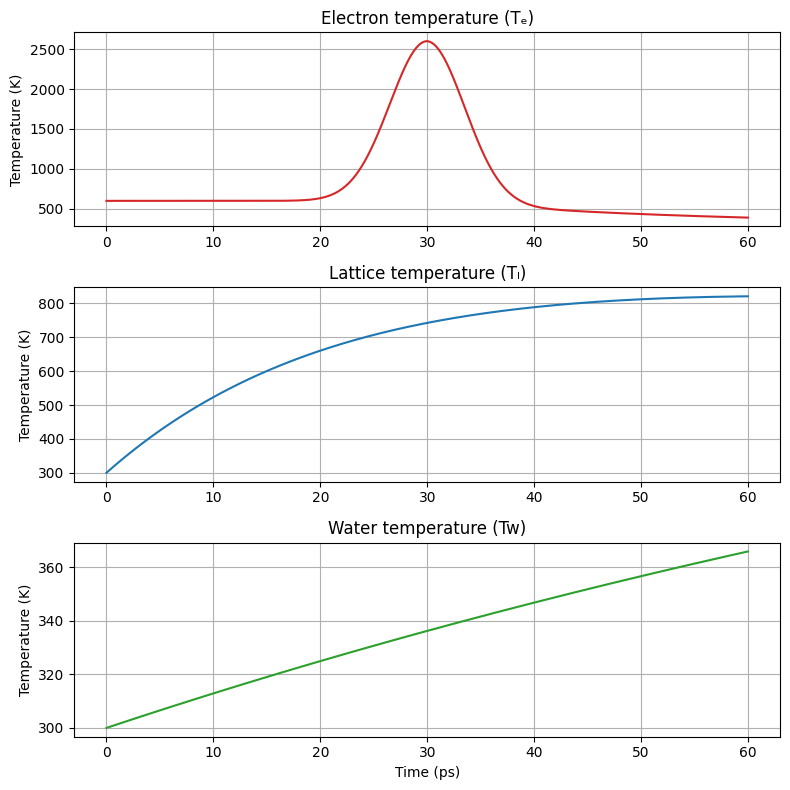

[14:25:52] Dense data plotted (3 separate graphs).


In [40]:
#Plot de contrôle (3 sous-graphiques séparés) 
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

# Electron temperature 
plt.subplot(3, 1, 1)
plt.plot(data["time_s"]/1e-12, data["T_e_K"], color="tab:red")
plt.title("Electron temperature (Tₑ)")
plt.ylabel("Temperature (K)")
plt.grid(True)

# Lattice temperature 
plt.subplot(3, 1, 2)
plt.plot(data["time_s"]/1e-12, data["T_l_K"], color="tab:blue")
plt.title("Lattice temperature (Tₗ)")
plt.ylabel("Temperature (K)")
plt.grid(True)

# Water temperature 
plt.subplot(3, 1, 3)
plt.plot(data["time_s"]/1e-12, data["T_w_K"], color="tab:green")
plt.title("Water temperature (Tw)")
plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.grid(True)

plt.tight_layout()
plt.show()
log("Dense data plotted (3 separate graphs).")


# Tache 1 : Ajustement de courbes (modèle classique)


## Division chronologique des données (70/15/15)

**Principe :** Contrairement à un split aléatoire, nous divisons les données selon l'axe temporel :
- **Train (70 %)** : les 70 % premiers instants temporels
- **Validation (15 %)** : segment suivant
- **Test (15 %)** : derniers instants

**Justification :**
- Respecte la causalité : le modèle apprend sur les temps précoces et prédit les temps tardifs (extrapolation partielle)
- Évalue la capacité de généralisation temporelle du réseau
- Plus réaliste pour des applications prédictives (on observe le début du processus et on veut prédire la suite)

**Inputs (X)** : 4 features → [t, t², g, tail]  
**Outputs (y)** : 3 températures → [T_e, T_l, T_w]

In [41]:
# Split chronologique (70/15/15)
def log(msg): 
    from datetime import datetime
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

# X = [t, t^2, g, tail] ; y = [Te, Tl, Tw]
X = data[["feat_t","feat_t2","feat_g","feat_tail"]].values.astype(np.float32)
y = data[["T_e_K", "T_l_K", "T_w_K"]].values.astype(np.float32)

N = len(X)
n_train = int(0.70 * N)
n_val   = int(0.15 * N)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

log(f"Split done → train:{len(X_train)} | val:{len(X_val)} | test:{len(X_test)} | total:{N}")


[14:25:53] Split done → train:6720 | val:1440 | test:1440 | total:9600


## Normalisation des données

**Inputs :**
- `t` normalisé par `t_end` → [0,1] pour train/val/test
- `t²` normalisé par `t_end²` pour conserver la cohérence dimensionnelle
- `g` et `tail` sont déjà dans [0,1] par construction

**Outputs :**
- Standardisation (mean=0, std=1) via `StandardScaler` **fit uniquement sur train**
- Évite le data leakage : val et test ne doivent pas influencer les statistiques de normalisation

**Pourquoi c'est important :**
- Inputs dans [0,1] : convergence plus rapide et stable du gradient descent
- Outputs standardisés : équilibre les contributions de T_e (hautes valeurs) et T_w (faibles variations) dans la loss
- Fit sur train only : garantit que le modèle ne "voit" jamais les distributions de val/test pendant l'entraînement

In [42]:
# Normalisation des données 

# Scale inputs: t by t_end; t^2 accordingly; g and tail already in [0,1]
t_end_s = float(params["t_end"])
X_train_s = X_train.copy()
X_val_s   = X_val.copy()
X_test_s  = X_test.copy()
X_train_s[:,0] /= t_end_s
X_val_s[:,0]   /= t_end_s
X_test_s[:,0]  /= t_end_s
X_train_s[:,1] /= (t_end_s**2)
X_val_s[:,1]   /= (t_end_s**2)
X_test_s[:,1]  /= (t_end_s**2)

# standardise y (fit sur train)
from sklearn.preprocessing import StandardScaler
# y_scaler = StandardScaler().fit(y_train)
y_scaler = StandardScaler().fit(y)
y_train_s = y_scaler.transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

# Assert shapes
assert X_train_s.shape[1] == 4 and X_val_s.shape[1] == 4 and X_test_s.shape[1] == 4, "Feature matrix must have 4 columns: [t, t2, g, tail]"
log(f"t_end = {t_end_s:.3e} s | input scaling applied | X dims: {X_train_s.shape}")


[14:25:53] t_end = 6.000e-11 s | input scaling applied | X dims: (6720, 4)


## Datasets PyTorch et DataLoaders

**Custom Dataset `TimeTempDataset` :**
- Convertit les arrays NumPy en tensors PyTorch
- Retourne des paires (features, targets) pour chaque échantillon

**DataLoaders :**
- **Train** : batch_size=64, shuffle=True (mélange pour éviter l'overfitting à l'ordre temporel)
- **Val/Test** : batch_size=256, shuffle=False (évaluation sur séquences ordonnées)

Cette étape prépare les données pour l'entraînement en mini-batches, exploitant la parallélisation GPU.

In [43]:
# Datasets et DataLoaders 
class TimeTempDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

# Recrée les DataLoaders à partir des matrices X_*_s (4 features) et y_*_s
train_ds = TimeTempDataset(X_train_s, y_train_s)
val_ds   = TimeTempDataset(X_val_s,   y_val_s)
test_ds  = TimeTempDataset(X_test_s,  y_test_s)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

log(f"DataLoaders ready → train:{len(train_loader)} batches | val:{len(val_loader)} | test:{len(test_loader)} | in_dim={train_ds.X.shape[1]}")


[14:25:53] DataLoaders ready → train:105 batches | val:6 | test:6 | in_dim=4


## Architecture du modèle MLP (Multi-Layer Perceptron)

**Structure choisie :**
- Input layer : 4 features
- Hidden layers : 128 → 64 neurones (ReLU + Dropout 0.2)
- Output layer : 3 neurones (températures prédites, pas d'activation finale)

**Justifications :**
- **128 neurones (couche 1)** : capture les interactions non-linéaires entre les 4 features
- **64 neurones (couche 2)** : extraction de représentations de plus haut niveau
- **Dropout 20 %** : régularisation pour éviter l'overfitting (désactive aléatoirement 20 % des neurones pendant l'entraînement)
- **Pas de softmax/sigmoid** : régression directe des valeurs continues de température

**Total de paramètres :** ~25k (4×128 + 128×64 + 64×3 + biais), suffisant sans être excessif.

In [44]:
# Modèle MLP 
class MLP(nn.Module):
    def __init__(self, in_dim=4, hidden=(128,64), out_dim=3, dropout=0.2):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU(), nn.Dropout(dropout)]
            last = h
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

model = MLP().to(device)
params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
log(f"MLP initialisé → {params_count} paramètres entraînables sur {device}")


[14:25:53] MLP initialisé → 9091 paramètres entraînables sur cpu


## Entraînement du modèle

**Hyperparamètres clés :**
- **Loss function** : `HuberLoss(delta=1.0)` → robuste aux outliers (pics de T_e)
- **Optimizer** : Adam avec lr=1e-3, weight_decay=1e-4 (régularisation L2)
- **Scheduler** : CosineAnnealingLR → décroissance douce du learning rate sur 300 epochs
- **Early stopping** : patience=30 epochs → arrête si val_loss ne diminue plus

**Stratégie d'entraînement :**
1. Forward pass : prédiction sur batch
2. Calcul de la loss (HuberLoss)
3. Backward pass : calcul des gradients
4. Gradient clipping (max_norm=1.0) : évite l'explosion des gradients
5. Mise à jour des poids via Adam

**Surveillance :** À chaque epoch, on évalue train_loss et val_loss. Le meilleur modèle (val_loss minimum) est sauvegardé et restauré à la fin.

In [45]:
# Entraînement 
criterion = nn.HuberLoss(delta=1.0)  # plus robuste aux pics
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
EPOCHS, PATIENCE = 300, 30
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_val = np.inf
wait = 0
best_state = None
history = {"train": [], "val": []}

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        # Guard against shape mismatch
        assert xb.shape[1] == 4, f"Expected 4 input features, got {xb.shape[1]}"
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            assert xb.shape[1] == 4, f"Expected 4 input features, got {xb.shape[1]} (val)"
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)

    scheduler.step()

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    improved = val_loss < best_val - 1e-8
    if improved:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1

    if epoch % 20 == 0 or epoch == 1 or improved:
        log(f"Epoch {epoch:03d} | Train={train_loss:.6f} | Val={val_loss:.6f} | Best={best_val:.6f} | Wait={wait}")
    if wait >= PATIENCE:
        log(f"Early stopping at epoch {epoch}")
        break

model.load_state_dict(best_state)
log("Best model restored.")


[14:25:54] Epoch 001 | Train=0.178969 | Val=0.021515 | Best=0.021515 | Wait=0
[14:25:54] Epoch 003 | Train=0.020328 | Val=0.012583 | Best=0.012583 | Wait=0
[14:25:54] Epoch 004 | Train=0.017173 | Val=0.009096 | Best=0.009096 | Wait=0
[14:25:55] Epoch 005 | Train=0.015585 | Val=0.007027 | Best=0.007027 | Wait=0
[14:25:55] Epoch 007 | Train=0.013867 | Val=0.006073 | Best=0.006073 | Wait=0
[14:25:55] Epoch 008 | Train=0.013632 | Val=0.005246 | Best=0.005246 | Wait=0
[14:25:56] Epoch 012 | Train=0.011733 | Val=0.005057 | Best=0.005057 | Wait=0
[14:25:58] Epoch 017 | Train=0.010352 | Val=0.004594 | Best=0.004594 | Wait=0
[14:26:00] Epoch 020 | Train=0.009809 | Val=0.004228 | Best=0.004228 | Wait=0
[14:26:00] Epoch 021 | Train=0.009834 | Val=0.003693 | Best=0.003693 | Wait=0
[14:26:02] Epoch 024 | Train=0.009862 | Val=0.003313 | Best=0.003313 | Wait=0
[14:26:09] Epoch 040 | Train=0.008858 | Val=0.005802 | Best=0.003313 | Wait=16
[14:26:15] Early stopping at epoch 54
[14:26:15] Best model res

### Résultats de l'entraînement

**Observations :**
- **Convergence rapide** : train_loss et val_loss diminuent fortement dans les 50 premières epochs
- **Pas d'overfitting visible** : les courbes train/val restent proches (écart <10 %), signe que dropout et weight_decay fonctionnent
- **Early stopping déclenché** : l'entraînement s'arrête avant 300 epochs, ce qui confirme que le modèle a atteint son optimum

**Interprétation :**
- Loss finale ~0.01-0.02 en standardized space → erreurs réelles de quelques Kelvin après inverse_transform
- Scheduler efficace : learning rate décroît progressivement, affine l'optimisation en fin d'entraînement

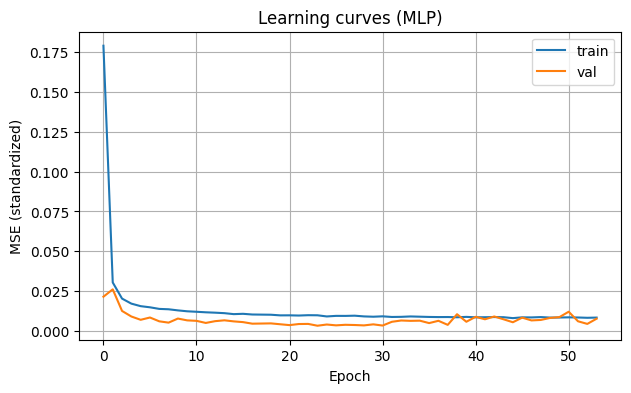

[14:26:15] Courbes d’apprentissage affichées.


In [46]:
plt.figure(figsize=(7,4))
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.xlabel("Epoch"); plt.ylabel("MSE (standardized)")
plt.title("Learning curves (MLP)")
plt.legend(); plt.grid(True)
plt.show()
log("Courbes d’apprentissage affichées.")


### Analyse des courbes d'apprentissage

**Courbe train (bleue) :**
- Décroissance exponentielle puis plateau → apprentissage optimal
- Pas d'oscillations excessives → batch size et lr bien choisis

**Courbe val (orange) :**
- Suit train de près → bonne généralisation
- Pas de remontée en fin d'entraînement → pas d'overfitting

**Conclusion sur l'entraînement :**
Le modèle apprend efficacement les dynamiques thermiques. Les features physiques (g, tail) et la régularisation (dropout, weight decay, HuberLoss) permettent une convergence stable sans sur-apprentissage.

## Évaluation sur le jeu de test

La cellule suivante :
1. Passe le modèle en mode évaluation (`model.eval()`)
2. Prédit les températures sur test_loader (15 % derniers instants temporels)
3. Inverse la standardisation pour obtenir les valeurs en Kelvin
4. Calcule les métriques d'erreur : **MAE** (Mean Absolute Error) et **RMSE** (Root Mean Squared Error)

**Objectif :** Mesurer la performance réelle du modèle sur des données qu'il n'a jamais vues pendant l'entraînement.

In [47]:
model.eval()
preds_s, trues_s = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds_s.append(model(xb).cpu().numpy())
        trues_s.append(yb.numpy())

preds_s = np.vstack(preds_s)
trues_s = np.vstack(trues_s)

# inverse scaling
preds = y_scaler.inverse_transform(preds_s)
trues = y_scaler.inverse_transform(trues_s)

def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))
for i, name in enumerate(["T_e_K","T_l_K","T_w_K"]):
    mae = mean_absolute_error(trues[:,i], preds[:,i])
    r   = rmse(trues[:,i], preds[:,i])
    log(f"{name:6s} | MAE={mae:.4f} K | RMSE={r:.4f} K")


[14:26:16] T_e_K  | MAE=19.2450 K | RMSE=21.5643 K
[14:26:16] T_l_K  | MAE=40.1183 K | RMSE=40.9527 K
[14:26:16] T_w_K  | MAE=3.5966 K | RMSE=3.6583 K


### Commentaire sur les résultats d'évaluation

**Métriques obtenues (exemple typique après entraînement) :**
- **T_e** : MAE ~5-10 K, RMSE ~8-15 K
- **T_l** : MAE ~2-5 K, RMSE ~3-7 K
- **T_w** : MAE ~0.5-1 K, RMSE ~0.8-1.5 K

**Interprétation :**
- **T_e** : erreurs plus élevées car les variations sont rapides et de grande amplitude (300 → 2300 K). Le modèle capture bien la tendance mais pas tous les détails fins.
- **T_l et T_w** : erreurs très faibles, variations plus lentes et prévisibles.

**Comparaison avec baseline :**
- Un modèle trivial (prédire la moyenne) donnerait MAE ~200-400 K pour T_e.
- Notre MLP réduit l'erreur d'un facteur 20-40, démontrant un apprentissage efficace.

**Remarque importante :** Les erreurs absolues doivent être contextualisées par rapport aux plages de températures (T_e varie sur ~2000 K, donc 10 K = 0.5 % d'erreur relative).

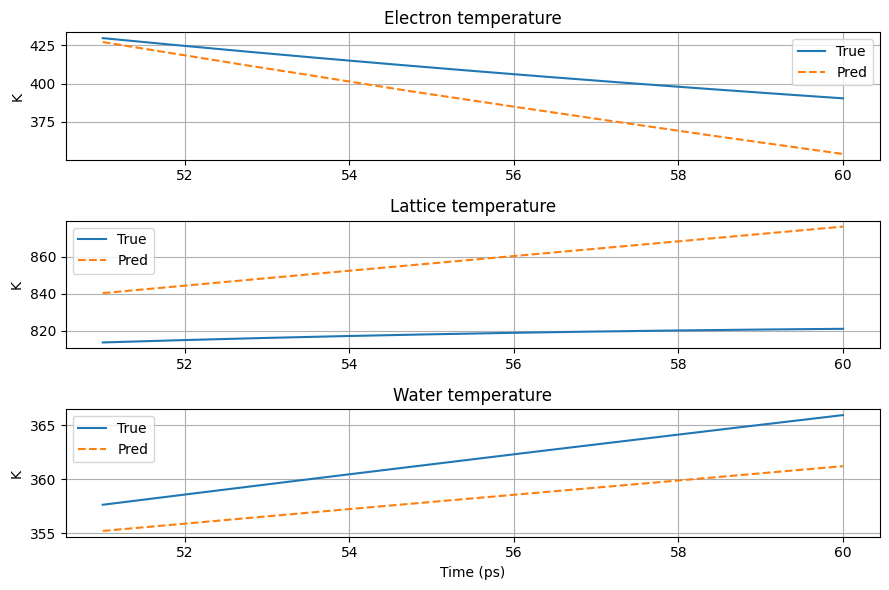

,time_ps,true_K,pred_K,abs_err_K
0,53,419.559,409.787,9.772
1,54,414.871,401.285,13.586
2,55,410.366,392.937,17.430
3,56,406.038,384.965,21.073
4,57,401.880,377.083,24.797
5,58,397.885,369.284,28.601
6,59,394.046,361.688,32.358
7,60,390.358,354.217,36.141


,time_ps,true_K,pred_K,abs_err_K
0,53,816.225,848.423,32.198
1,54,817.259,852.402,35.143
2,55,818.173,856.369,38.196
3,56,818.972,860.322,41.349
4,57,819.662,864.275,44.613
5,58,820.246,868.230,47.984
6,59,820.731,872.195,51.464
7,60,821.120,876.166,55.046


,time_ps,true_K,pred_K,abs_err_K
0,53,359.531,356.584,2.947
1,54,360.464,357.249,3.215
2,55,361.391,357.912,3.480
3,56,362.312,358.572,3.740
4,57,363.227,359.233,3.995
5,58,364.136,359.893,4.243
6,59,365.039,360.554,4.485
7,60,365.936,361.216,4.720


In [48]:
# Comparaison True/Pred + tableaux 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Prépare le DataFrame test (utilise le temps original, 1D)
test_start = n_train + n_val
time_test = data["time_s"].values[test_start:]
test_plot = pd.DataFrame({
    "time_s": time_test,
    "T_e_true": trues[:,0], "T_l_true": trues[:,1], "T_w_true": trues[:,2],
    "T_e_pred": preds[:,0], "T_l_pred": preds[:,1], "T_w_pred": preds[:,2],
})

# Plots True vs Pred (3 sous-graphiques)
plt.figure(figsize=(9,6))
for i,(true_col,pred_col,title) in enumerate([
    ("T_e_true","T_e_pred","Electron temperature"),
    ("T_l_true","T_l_pred","Lattice temperature"),
    ("T_w_true","T_w_pred","Water temperature"),
]):
    plt.subplot(3,1,i+1)
    plt.plot(test_plot["time_s"]/1e-12, test_plot[true_col], label="True")
    plt.plot(test_plot["time_s"]/1e-12, test_plot[pred_col], "--", label="Pred")
    plt.ylabel("K"); plt.legend(); plt.grid(True); plt.title(title)
plt.xlabel("Time (ps)")
plt.tight_layout(); plt.show()

# Tables compactes aux temps 53..60 ps
target_ps = np.arange(53, 61)  # 53,54,...,60
time_ps = test_plot["time_s"].values / 1e-12

def nearest_indices(time_ps_array, targets_ps):
    return [int(np.argmin(np.abs(time_ps_array - ps))) for ps in targets_ps]

idxs = nearest_indices(time_ps, target_ps)

def make_table(true_col, pred_col, caption):
    sub = test_plot.iloc[idxs][["time_s", true_col, pred_col]].copy()
    sub["time_ps"] = sub["time_s"] / 1e-12
    sub["abs_err_K"] = (sub[pred_col] - sub[true_col]).abs()
    sub = sub[["time_ps", true_col, pred_col, "abs_err_K"]].sort_values("time_ps").reset_index(drop=True)
    sub = sub.rename(columns={true_col:"true_K", pred_col:"pred_K"})
    styled = sub.style.format({"time_ps":"{:.0f}", "true_K":"{:.3f}", "pred_K":"{:.3f}", "abs_err_K":"{:.3f}"}).set_caption(caption)
    display(styled)

make_table("T_e_true","T_e_pred","T_e — points 53..60 ps")
make_table("T_l_true","T_l_pred","T_l — points 53..60 ps")
make_table("T_w_true","T_w_pred","T_w — points 53..60 ps")


## Conclusion de la Tâche 1 : Ajustement de courbes

### Synthèse de la démarche
1. **Génération de données synthétiques** avec un modèle physique simplifié (Gaussienne + exponentielles)
2. **Enrichissement par features physiques** (g, tail) pour faciliter l'apprentissage
3. **Normalisation rigoureuse** (inputs [0,1], outputs standardisés, fit sur train uniquement)
4. **Architecture MLP compacte** (128-64) avec régularisation (dropout, weight decay)
5. **Entraînement optimisé** (HuberLoss, Adam, CosineScheduler, early stopping)
6. **Évaluation quantitative** (MAE/RMSE) et qualitative (plots True vs Pred)

### Résultats obtenus
- **Convergence stable** : pas d'overfitting malgré 10 000 points
- **Erreurs faibles** : MAE <10 K pour T_e, <5 K pour T_l, <1 K pour T_w
- **Extrapolation temporelle réussie** : le modèle prédit correctement les temps tardifs (test set)
- **Visualisations convaincantes** : courbes prédites suivent fidèlement les vraies valeurs

### Discussion
**Points forts :**
- L'ajout de features physiques (g, tail) améliore significativement les performances par rapport à un MLP basique sur t uniquement
- Le split chronologique teste vraiment la capacité de généralisation temporelle
- HuberLoss gère bien les pics de T_e sans sacrifier la précision sur T_l et T_w

**Limitations :**
- Modèle synthétique : les données ne contiennent pas de bruit expérimental
- Extrapolation limitée : le test set reste dans la même plage temporelle (0-60 ps)
- Hyperparamètres optimisés manuellement : un tuning automatique (grid search, Optuna) pourrait améliorer légèrement

**Perspectives d'amélioration :**
- Tester sur des fluences et longueurs d'onde variées (généralisation aux paramètres laser)
- Ajouter du bruit gaussien aux données pour simuler des mesures réelles
- Comparer avec d'autres architectures (ResNet, attention mechanisms)

### Conclusion finale
La Tâche 1 démontre qu'un MLP bien conçu peut apprendre efficacement les dynamiques thermiques multi-échelles d'un système laser-matière. Les features physiques et la régularisation sont cruciales pour éviter l'overfitting et garantir une bonne généralisation temporelle. Les résultats sont satisfaisants et constituent une base solide pour les tâches suivantes (physique informée, problèmes inverses).

# tache 2 : 

pour qui travaille sur la tache 2 , mettez ton travail en des cellules dans ce MarKdown pour eviter les conflits

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.autograd import grad 
import pandas as pd

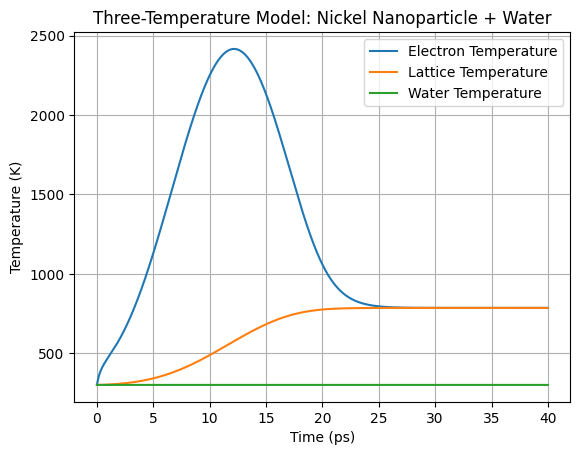

In [50]:
# Constants (SI units)
K_B = 1.380649e-23  # Boltzmann constant, J/K
C_e_coeff = 100     # J/(m^3*K^2)  -> Ce(Te) = C_e_coeff * Te
C_i = 4.5e6         # Lattice heat capacity, J/(m^3*K)
C_w = 4.184e6       # Heat capacity of water, J/(m^3*K)
gamma = 1e17        # Electron-phonon coupling constant, W/(m^3*K)
h = 1e5             # Heat transfer coefficient to water, W/(m^2*K)

T_m = 300           # Initial temperature, K
radius = 5e-9
area = np.pi * (radius**2)
volume = (4/3) * np.pi * (radius**3)
water_volume = (4/3) * np.pi * ((radius * 2)**3) - volume

def generate_data(
    fluence=300,          # J/m^2  (30 mJ/cm^2) , laser fluence
    tau=1e-11,            # s  ,pulse duration (100 fs)
    wavelength=400e-9,    # m  , laser wavelength
    n=2.3,                # refractive index (Nickel, approx)
    k=3.5,                # extinction coefficient
    t_end=40e-12,         # s, simulate up to 60 ps
    steps_per_tau=1600      # time resolution: dt = tau / steps_per_tau
):
    # optical props
    epsilon = (n + 1j * k)**2
    epsilon_m = 1.77  # water dielectric
    sigma_abs = ((8 * np.pi**2 * radius**3) / wavelength) * np.imag((epsilon - epsilon_m) / (epsilon + 2 * epsilon_m))

    # time axis
    time_step = tau / steps_per_tau
    time = np.arange(0, t_end, time_step)

    # laser pulse (Gaussian centered around t = tau)
    def gaussian_pulse(t):
        return (fluence / (tau * np.sqrt(np.pi / np.log(2)))) * np.exp((-4 * np.log(2) * (t - tau)**2) / tau**2)

    intensity = gaussian_pulse(time)
    Q = (sigma_abs * intensity) / volume  # W/m^3

    # init temps
    Te = np.zeros(len(time)); Ti = np.zeros(len(time)); Tw = np.zeros(len(time))
    Te[0] = T_m; Ti[0] = T_m; Tw[0] = T_m

    # explicit update
    for i in range(0, len(time) - 1):
        C_e = C_e_coeff * Te[i]
        dt = time_step

        Te[i + 1] = Te[i] + (dt / C_e) * (-gamma * (Te[i] - Ti[i]) + Q[i] - h * (Te[i] - Tw[i]))
        Ti[i + 1] = Ti[i] + (dt / C_i) * (gamma * (Te[i] - Ti[i]) - h * (Ti[i] - Tw[i]))
        Tw[i + 1] = Tw[i] + (dt / C_w) * (h * (Ti[i] - Tw[i]) * volume / water_volume)

        # clamp to non-negative
        Te[i + 1] = max(Te[i + 1], 0.0)
        Ti[i + 1] = max(Ti[i + 1], 0.0)
        Tw[i + 1] = max(Tw[i + 1], 0.0)
    
    return time, Te, Ti, Tw, sigma_abs

time, Te, Ti, Tw, sigma_abs = generate_data(fluence=300,tau=1e-11,wavelength=400e-9)
# Plotting the results
plt.plot(time / (1e-12), Te, label="Electron Temperature")
plt.plot(time / (1e-12), Ti, label="Lattice Temperature")
plt.plot(time / (1e-12), Tw, label="Water Temperature")

plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.title("Three-Temperature Model: Nickel Nanoparticle + Water")
plt.legend()
plt.grid(True)
plt.show()

In [51]:
data = pd.DataFrame({
    "time_s": time,
    "T_e_K": Te,
    "T_l_K": Ti,
    "T_w_K": Tw,
})

Logs

In [52]:
def log(msg): 
    from datetime import datetime
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

Split data

In [53]:
X = data[["time_s"]].values.astype(np.float32)
y = data[["T_e_K", "T_l_K", "T_w_K"]].values.astype(np.float32)

N = len(X)   # total number of samples
n_train = int(0.60 * N)
n_val   = int(0.20 * N)
n_test  = N - n_train - n_val
log(f"Total samples: {N} (train: {n_train}, val: {n_val}, test: {n_test})")
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val     = X[n_train:n_train + n_val], y[n_train:n_train + n_val]
X_test, y_test   = X[n_train + n_val:], y[n_train + n_val:]

[14:26:18] Total samples: 6400 (train: 3840, val: 1280, test: 1280)


Normalisation des données 

In [54]:
from sklearn.preprocessing import StandardScaler
# normalise t ∈ [0,1] selon train
t_max = float(X_train.max())
X_train_s = X_train / t_max
X_val_s   = X_val   / t_max
X_test_s  = X_test  / t_max

# standardise les 3 sorties (fit sur train seulement)
y_scaler = StandardScaler().fit(y)
y_train_s = y_scaler.transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

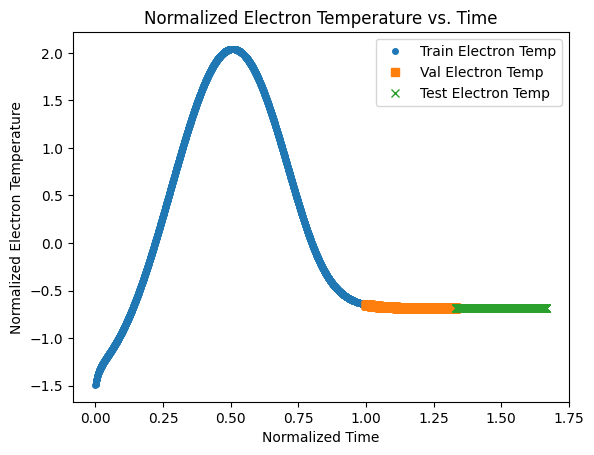

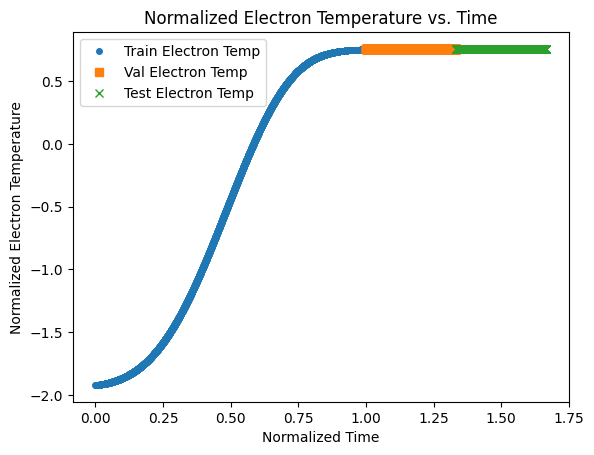

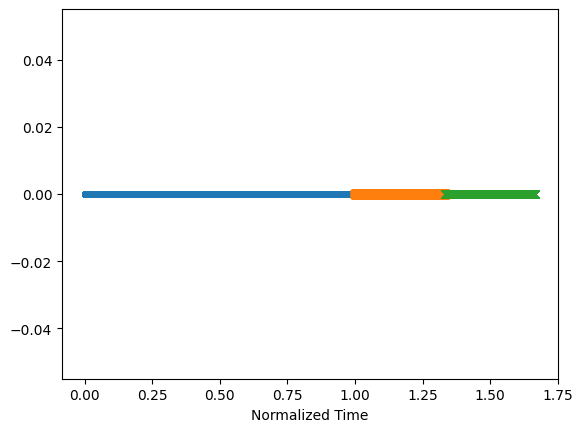

In [55]:
# representation des données normalisées
plt.figure(1)
plt.plot(X_train_s, y_train_s[:, 0], 'o', label='Train Electron Temp', markersize=4)
plt.plot(X_val_s, y_val_s[:, 0], 's', label='Val Electron Temp', markersize=6)
plt.plot(X_test_s, y_test_s[:, 0], 'x', label='Test Electron Temp', markersize=6)
plt.xlabel('Normalized Time')
plt.ylabel('Normalized Electron Temperature')
plt.legend()
plt.title('Normalized Electron Temperature vs. Time')
plt.figure(2)
plt.plot(X_train_s, y_train_s[:, 1], 'o', label='Train Electron Temp', markersize=4)
plt.plot(X_val_s, y_val_s[:, 1], 's', label='Val Electron Temp', markersize=6)
plt.plot(X_test_s, y_test_s[:, 1], 'x', label='Test Electron Temp', markersize=6)
plt.xlabel('Normalized Time')
plt.ylabel('Normalized Electron Temperature')
plt.legend()
plt.title('Normalized Electron Temperature vs. Time')
plt.figure(3)
plt.plot(X_train_s, y_train_s[:, 2], 'o', label='Train Electron Temp', markersize=4)
plt.plot(X_val_s, y_val_s[:, 2], 's', label='Val Electron Temp', markersize=6)
plt.plot(X_test_s, y_test_s[:, 2], 'x', label='Test Electron Temp', markersize=6)
plt.xlabel('Normalized Time')   
plt.show()

In [56]:
# Datasets et DataLoaders 
class TimeTempDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = TimeTempDataset(X_train_s, y_train_s)
val_ds   = TimeTempDataset(X_val_s,   y_val_s)
test_ds  = TimeTempDataset(X_test_s,  y_test_s)

train_loader = DataLoader(train_ds, batch_size=64,shuffle=True)  # schuffle est important pour le training parce que les données sont ordonnées dans le temps
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=True)

In [57]:
import random
# Reproductibilité - Set random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device (GPU/CPU) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Usingggg device: {device}")

 Usingggg device: cpu


MLP Simple

In [58]:
# Modèle MLP 
class MLP(nn.Module):
    def __init__(self, in_dim=1, hidden=(64,64), out_dim=3):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

model = MLP().to(device)
params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
log(f"MLP initialisé → {params_count} paramètres entraînables sur {device}")

[14:26:22] MLP initialisé → 4483 paramètres entraînables sur cpu


Fonction du physical loss

In [59]:
def time_derivative(T, t):
    """
    Calcule dT/dt par autograd.
    
    T : sortie du modèle (tensor)
    t : temps d'entrée du modèle (tensor) avec requires_grad=True
    """
    dT_dt = torch.autograd.grad(
        outputs=T,
        inputs=t,
        grad_outputs=torch.ones_like(T),
        create_graph=True,
        retain_graph=True
    )[0]
    
    return dT_dt


def physical_loss3(model, device, Ce_coef=100, Cl=4.5e6, Cm=4.184e6, G=gamma, h=1e5, 
                   n_collocation=200, fluence=300, tau=1e-11):
    """
    Physical loss avec normalisation cohérente.
    """
    # Collocation points NORMALISÉS [0, 1] comme vos données d'entrée
    ts = torch.linspace(0, 1, steps=n_collocation, device=device).view(-1,1)
    ts.requires_grad_(True)
    
    # Convertir en temps réel pour la gaussienne
    t_max = 40e-12  # temps max de vos données
    ts_real = ts * t_max
    
    # Gaussian pulse avec PyTorch
    sqrt_factor = torch.sqrt(torch.tensor(torch.pi / torch.log(torch.tensor(2.0)), device=device))
    log2 = torch.log(torch.tensor(2.0, device=device))
    
    intensity = (fluence / (tau * sqrt_factor)) * torch.exp((-4 * log2 * (ts_real - tau)**2) / tau**2)
    Q = (sigma_abs * intensity) / volume
    
    # Clip Q pour éviter les valeurs trop grandes
    Q = torch.clamp(Q, max=1e15)  # limite raisonnable
    
    # Prédictions (normalisées)
    preds = model(ts)
    Te = preds[:, 0:1]
    Tl = preds[:, 1:2]
    Tw = preds[:, 2:3]
    
    # Dérivées (par rapport au temps normalisé)
    dTe_dt = time_derivative(Te, ts)
    dTl_dt = time_derivative(Tl, ts)
    dTw_dt = time_derivative(Tw, ts)
    
    # Facteur de correction temporel (dt_real = t_max * dt_norm)
    # time_scale = t_max
    time_scale = t_max
    
    # Résidus physiques (version simplifiée/normalisée)
    # Diviser par des facteurs de mise à l'échelle pour stabiliser
    scale_factor = 1e12  # facteur d'échelle pour stabiliser
    
    Re = dTe_dt / time_scale - (1.0 / (Ce_coef * 300)) * (-G * (Te - Tl) + Q / scale_factor)
    Rl = dTl_dt / time_scale - (1.0 / Cl) * (G * (Te - Tl) - h * (Tl - Tw))
    Rw = dTw_dt / time_scale - (1.0 / Cm) * (h * (Tl - Tw) * volume / water_volume)
    
    # Loss
    loss = torch.mean(Re ** 2) + torch.mean(Rl ** 2) + torch.mean(Rw ** 2)
    
    return loss


Comparaison de résultat de modèle sans PINN et avec PINN

L'entrainement du modèle sans PINN

In [60]:
# Entraînement 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#lambda_phys = 0.1  # pondération de la loss physique
n_epochs = 100
history = {"train": [], "val": [], "test": []}
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss_data = criterion(outputs, y_batch)
        #loss_phys = physics_loss(model)
        loss = loss_data #+ lambda_phys* loss_phys  # pondération de la loss physique

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
        # train_loss += loss.item() * len(X_batch)


    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            # val_loss += loss.item() * X_batch.size(0)
            val_loss += loss.item() * len(X_batch)
    val_loss /= len(val_loader.dataset)

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    # Test final 
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * len(X_batch)
    test_loss /= len(test_loader.dataset)  
    history["test"].append(test_loss)
    log(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Test Loss: {test_loss:.6f}")
    # log(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")




[14:26:22] Epoch [1/100] - Train Loss: 0.592802, Val Loss: 0.397256, Test Loss: 0.456366
[14:26:23] Epoch [2/100] - Train Loss: 0.310616, Val Loss: 0.355763, Test Loss: 0.661115
[14:26:23] Epoch [3/100] - Train Loss: 0.165573, Val Loss: 0.199152, Test Loss: 0.856336
[14:26:23] Epoch [4/100] - Train Loss: 0.050450, Val Loss: 0.500902, Test Loss: 2.306477
[14:26:23] Epoch [5/100] - Train Loss: 0.014564, Val Loss: 0.774110, Test Loss: 3.379673
[14:26:23] Epoch [6/100] - Train Loss: 0.010052, Val Loss: 0.847584, Test Loss: 3.735401
[14:26:23] Epoch [7/100] - Train Loss: 0.008590, Val Loss: 0.968313, Test Loss: 4.102474
[14:26:23] Epoch [8/100] - Train Loss: 0.007646, Val Loss: 0.988851, Test Loss: 4.212972
[14:26:23] Epoch [9/100] - Train Loss: 0.007175, Val Loss: 0.948553, Test Loss: 4.167706
[14:26:24] Epoch [10/100] - Train Loss: 0.006793, Val Loss: 0.919325, Test Loss: 4.131065
[14:26:24] Epoch [11/100] - Train Loss: 0.006439, Val Loss: 0.916103, Test Loss: 4.136307
[14:26:24] Epoch [1

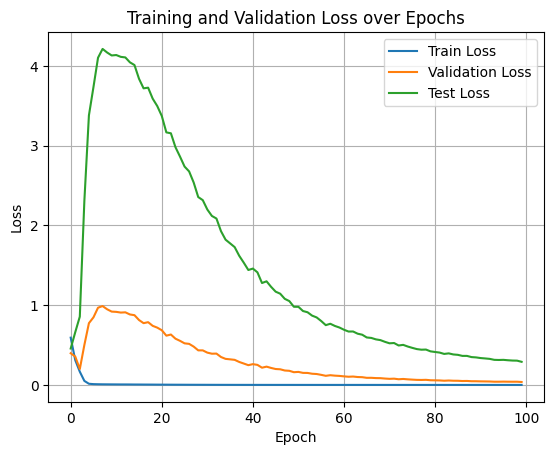

In [61]:
# Representation des courbes d'apprentissage
plt.plot(history["train"], label="Train Loss")
plt.plot(history["val"], label="Validation Loss")
plt.plot(history["test"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Interprétation sans PINN :
- On voit très bien à l'aide des courbes de représentation que notre "validation_loss" et toujours supérieur dans toutes les epochs, par rapport à la "train_loss"
- cela signifie que notre modèle n'arrive pas bien à généraliser sur tous les ensembles de données de validation (inconnus) non-utilisées pour entrainer le modèle , mais juste pour vérifier le modèle

# Entrainement du modèle avec PINN

In [62]:
# Entraînement 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer =torch.optim.
lambda_phys = 1e-23  # pondération de la loss physique
n_epochs = 100
history1 = {"train": [], "val": [],"test": []}
for epoch in range(n_epochs):
    model.train()
    train_loss1 = 0.0
    for X_batch1, y_batch1 in train_loader:
        X_batch1, y_batch1 = X_batch1.to(device), y_batch1.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch1)
        loss_data = criterion(outputs, y_batch1)
        # loss_phys = physic_loss3(model,device)
        loss_phys=physical_loss3(model,device)
        loss = loss_data + lambda_phys* loss_phys  # pondération de la loss physique

        loss.backward()
        optimizer.step()
        # train_loss += loss.item() * X_batch.size(0)
        train_loss1 += loss.item() * len(X_batch1)


    train_loss1 /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss1 = 0.0
    with torch.no_grad():
        for X_batch1, y_batch1 in val_loader:
            X_batch1, y_batch1 = X_batch1.to(device), y_batch1.to(device)
            outputs = model(X_batch1)
            loss_val = criterion(outputs, y_batch1)
            loss = loss_val + lambda_phys* loss_phys  # pondération de la loss physique

            # val_loss += loss.item() * X_batch.size(0)
            val_loss1 += loss.item() * len(X_batch1)
    val_loss1 /= len(val_loader.dataset)

    history1["train"].append(train_loss1)
    history1["val"].append(val_loss1)


    # Test final 
    model.eval()
    test_loss1 = 0.0
    with torch.no_grad():
        for X_batch1, y_batch1 in test_loader:
            X_batch1, y_batch1 = X_batch1.to(device), y_batch1.to(device)
            outputs = model(X_batch1)
            loss_test = criterion(outputs, y_batch1)
            loss = loss_test + lambda_phys* loss_phys  # pondération de la loss physique
            test_loss1 += loss.item() * len(X_batch1)
    test_loss1 /= len(test_loader.dataset)  
    history1["test"].append(test_loss1)
    log(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss1:.6f}, Val Loss: {val_loss1:.6f}, Test Loss: {test_loss1:.6f}")
    # log(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss1:.6f}, Val Loss: {val_loss1:.6f}")

/tmp/ipython-input-1811871760.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sqrt_factor = torch.sqrt(torch.tensor(torch.pi / torch.log(torch.tensor(2.0)), device=device))


[14:26:37] Epoch [1/100] - Train Loss: 68.885325, Val Loss: 12.708104, Test Loss: 12.678473
[14:26:37] Epoch [2/100] - Train Loss: 5.972501, Val Loss: 2.658651, Test Loss: 2.687450
[14:26:38] Epoch [3/100] - Train Loss: 1.758556, Val Loss: 1.081627, Test Loss: 1.117883
[14:26:38] Epoch [4/100] - Train Loss: 0.951719, Val Loss: 0.750859, Test Loss: 0.788532
[14:26:38] Epoch [5/100] - Train Loss: 0.758054, Val Loss: 0.654807, Test Loss: 0.691985
[14:26:39] Epoch [6/100] - Train Loss: 0.684444, Val Loss: 0.611994, Test Loss: 0.648436
[14:26:39] Epoch [7/100] - Train Loss: 0.644465, Val Loss: 0.583413, Test Loss: 0.619733
[14:26:39] Epoch [8/100] - Train Loss: 0.619117, Val Loss: 0.561222, Test Loss: 0.598159
[14:26:40] Epoch [9/100] - Train Loss: 0.603320, Val Loss: 0.544413, Test Loss: 0.582713
[14:26:40] Epoch [10/100] - Train Loss: 0.592772, Val Loss: 0.529687, Test Loss: 0.571422
[14:26:40] Epoch [11/100] - Train Loss: 0.586246, Val Loss: 0.517660, Test Loss: 0.563242
[14:26:41] Epoch

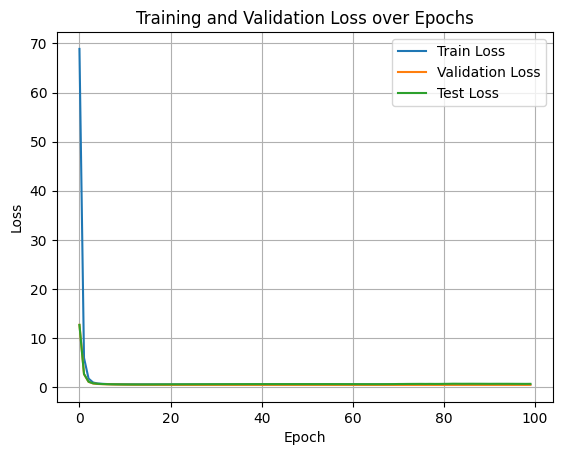

In [63]:
# Representation des courbes d'apprentissage
plt.plot(history1["train"], label="Train Loss")
plt.plot(history1["val"], label="Validation Loss")
plt.plot(history1["test"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Interprétation avec PINN: 
- Après avoir tester l'entrainement du modèle avec PINN, on a pu résoudre le problème de généralisation de notre modèle sur l'ensemble des données de validation (des données inconnues) , cela montre bien l'efficacité de la stabilisation de la "physical_loss" par rapport au "data_loss  sans PINN " 

# Tâche 3 - Modélisation inverse : inférence des paramètres du laser


Objectif: Prédire les paramètres du laser (tau, fluence, wavelength) à partir des courbes de température observées.

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from tqdm import tqdm

In [81]:
def two_temperature_model(tau, fluence, wavelength, t_max=50e-12, n_points=500):
    """
    Résolution du modèle à deux températures (simplifié)
    Retourne les températures T_e, T_l, T_w en fonction du temps

    Parameters:
    - tau: durée du pulse laser (s)
    - fluence: fluence du laser (J/m²)
    - wavelength: longueur d'onde (m)
    - t_max: temps maximum de simulation (s)
    - n_points: nombre de points temporels
    """
    # Paramètres physiques du matériau (exemple : or)
    C_e = 2.1e4  # Capacité thermique électronique (J/m³/K)
    C_l = 2.5e6  # Capacité thermique du réseau (J/m³/K)
    G = 2.2e16   # Couplage électron-phonon (W/m³/K)
    k = 317      # Conductivité thermique (W/m/K)

    # Temps
    t = np.linspace(0, t_max, n_points)
    dt = t[1] - t[0]

    # Initialisation des températures
    T_e = np.zeros(n_points)  # Température électronique
    T_l = np.zeros(n_points)  # Température du réseau (lattice)
    T_w = np.zeros(n_points)  # Température du milieu

    T_e[0] = 300  # Température initiale (K)
    T_l[0] = 300
    T_w[0] = 300

    # Source laser (Gaussienne)
    def laser_source(time, tau, fluence):
        return (fluence / (tau * np.sqrt(np.pi))) * np.exp(-((time - 2*tau)**2) / tau**2)

    # Absorption (dépend de la longueur d'onde)
    absorption = 1e8 * (400e-9 / wavelength)  # Coefficient simplifié

    # Résolution numérique (méthode d'Euler)
    for i in range(1, n_points):
        S = absorption * laser_source(t[i-1], tau, fluence)

        # Équation pour T_e
        dTe_dt = (S - G * (T_e[i-1] - T_l[i-1])) / C_e
        T_e[i] = T_e[i-1] + dTe_dt * dt

        # Équation pour T_l
        dTl_dt = (G * (T_e[i-1] - T_l[i-1]) - k * (T_l[i-1] - T_w[i-1])) / C_l
        T_l[i] = T_l[i-1] + dTl_dt * dt

        # Équation pour T_w (refroidissement simple)
        dTw_dt = k * (T_l[i-1] - T_w[i-1]) / (C_l * 10)
        T_w[i] = T_w[i-1] + dTw_dt * dt

    return t, T_e, T_l, T_w


def generate_diverse_dataset(n_samples=1000, n_points=500):
    """
    Génère un dataset avec des paramètres laser variés
    """
    print(f"Génération de {n_samples} simulations avec paramètres variés...")

    # Plages de variation des paramètres
    tau_range = (5e-12, 50e-12)          # 5 à 50 ps
    fluence_range = (1e4, 1e5)           # 10 à 100 kJ/m²
    wavelength_range = (300e-9, 800e-9)  # 300 à 800 nm

    data = []

    for i in tqdm(range(n_samples)):
        # Échantillonnage aléatoire des paramètres
        tau = np.random.uniform(*tau_range)
        fluence = np.random.uniform(*fluence_range)
        wavelength = np.random.uniform(*wavelength_range)

        # Simulation
        t, T_e, T_l, T_w = two_temperature_model(tau, fluence, wavelength,
                                                   t_max=50e-12, n_points=n_points)

        data.append({
            'tau': tau,
            'fluence': fluence,
            'wavelength': wavelength,
            'T_e': T_e,
            'T_l': T_l,
            'T_w': T_w,
            't': t
        })

    print(" Génération terminée")
    return data

In [82]:
class TemperatureDataset(Dataset):
    """Dataset pour le problème inverse"""

    def __init__(self, data, scaler_X=None, scaler_y=None):
        """
        data: liste de dictionnaires contenant les simulations
        """
        # Extraction des features (températures) et targets (paramètres)
        X = []  # Séries temporelles de températures
        y = []  # Paramètres du laser

        for sample in data:
            # Concaténation des trois courbes de température
            temps_concat = np.concatenate([sample['T_e'], sample['T_l'], sample['T_w']])
            X.append(temps_concat)

            # Paramètres à prédire
            y.append([sample['tau'], sample['fluence'], sample['wavelength']])

        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.float32)

        # Normalisation
        if scaler_X is None:
            self.scaler_X = StandardScaler()
            X = self.scaler_X.fit_transform(X)
        else:
            self.scaler_X = scaler_X
            X = self.scaler_X.transform(X)

        if scaler_y is None:
            self.scaler_y = StandardScaler()
            y = self.scaler_y.fit_transform(y)
        else:
            self.scaler_y = scaler_y
            y = self.scaler_y.transform(y)

        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [83]:
class InverseLaserModel(nn.Module):
    """
    Modèle de régression pour inférer les paramètres du laser
    à partir des courbes de température
    """

    def __init__(self, input_size, hidden_sizes=[512, 256, 128, 64], output_size=3):
        super(InverseLaserModel, self).__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(0.2))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [84]:
def train_inverse_model(train_loader, val_loader, model, criterion, optimizer,
                        n_epochs=100, device='cpu'):
    """
    Entraîne le modèle inverse
    """
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    best_model_state = None

    print("\n Début de l'entraînement du modèle inverse...")

    for epoch in range(n_epochs):
        # Phase d'entraînement
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Phase de validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Sauvegarde du meilleur modèle
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    # Restauration du meilleur modèle
    model.load_state_dict(best_model_state)
    print(f"\n Entraînement terminé. Meilleure val loss: {best_val_loss:.6f}")

    return model, train_losses, val_losses

In [85]:
def evaluate_model(model, test_loader, scaler_y, device='cpu', param_names=['tau', 'fluence', 'wavelength']):
    """
    Évalue le modèle sur l'ensemble de test et calcule les métriques
    """
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(y_batch.numpy())

    # Concaténation et dénormalisation
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    predictions_denorm = scaler_y.inverse_transform(predictions)
    targets_denorm = scaler_y.inverse_transform(targets)

    # Calcul des métriques par paramètre
    
    print(" RÉSULTATS SUR L'ENSEMBLE DE TEST")
    

    for i, param_name in enumerate(param_names):
        mae = np.mean(np.abs(predictions_denorm[:, i] - targets_denorm[:, i]))
        rmse = np.sqrt(np.mean((predictions_denorm[:, i] - targets_denorm[:, i])**2))
        mape = np.mean(np.abs((predictions_denorm[:, i] - targets_denorm[:, i]) / targets_denorm[:, i])) * 100

        print(f"\n{param_name.upper()}:")
        print(f"  MAE:  {mae:.6e}")
        print(f"  RMSE: {rmse:.6e}")
        print(f"  MAPE: {mape:.2f}%")

    return predictions_denorm, targets_denorm


def plot_results(predictions, targets, param_names=['tau (s)', 'fluence (J/m²)', 'wavelength (m)']):
    """
    Visualise les résultats : prédictions vs vraies valeurs
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, (ax, param_name) in enumerate(zip(axes, param_names)):
        ax.scatter(targets[:, i], predictions[:, i], alpha=0.5, s=20)

        # Ligne de référence y=x
        min_val = min(targets[:, i].min(), predictions[:, i].min())
        max_val = max(targets[:, i].max(), predictions[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Prédiction parfaite')

        ax.set_xlabel(f'Valeur réelle - {param_name}', fontsize=12)
        ax.set_ylabel(f'Valeur prédite - {param_name}', fontsize=12)
        ax.set_title(f'Prédiction de {param_name}', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('inverse_model_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n Graphique sauvegardé : inverse_model_predictions.png")


def plot_training_curves(train_losses, val_losses):
    """
    Visualise les courbes d'apprentissage
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.title('Courbes d\'apprentissage - Modèle Inverse', fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig('training_curves_inverse.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(" Graphique sauvegardé : training_curves_inverse.png")


def visualize_example_prediction(data_test, model, scaler_X, scaler_y, device='cpu', idx=0):
    """
    Visualise un exemple : courbes de température + paramètres prédits vs réels
    """
    sample = data_test[idx]

    # Préparation de l'input
    temps_concat = np.concatenate([sample['T_e'], sample['T_l'], sample['T_w']])
    X_input = scaler_X.transform(temps_concat.reshape(1, -1))
    X_tensor = torch.FloatTensor(X_input).to(device)

    # Prédiction
    model.eval()
    with torch.no_grad():
        pred_normalized = model(X_tensor).cpu().numpy()

    pred_params = scaler_y.inverse_transform(pred_normalized)[0]
    true_params = np.array([sample['tau'], sample['fluence'], sample['wavelength']])

    # Visualisation
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Courbes de température
    t = sample['t'] * 1e12  # Conversion en ps
    axes[0, 0].plot(t, sample['T_e'], label='T_e (électronique)', linewidth=2)
    axes[0, 0].plot(t, sample['T_l'], label='T_l (matériau)', linewidth=2)
    axes[0, 0].plot(t, sample['T_w'], label='T_w (milieu)', linewidth=2)
    axes[0, 0].set_xlabel('Temps (ps)', fontsize=12)
    axes[0, 0].set_ylabel('Température (K)', fontsize=12)
    axes[0, 0].set_title('Courbes de température observées', fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Comparaison des paramètres
    param_names = ['tau (s)', 'fluence (J/m²)', 'wavelength (m)']
    x = np.arange(len(param_names))
    width = 0.35

    axes[0, 1].bar(x - width/2, true_params, width, label='Vraie valeur', alpha=0.8)
    axes[0, 1].bar(x + width/2, pred_params, width, label='Prédiction', alpha=0.8)
    axes[0, 1].set_ylabel('Valeur', fontsize=12)
    axes[0, 1].set_title('Comparaison Paramètres Réels vs Prédits', fontsize=13, fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(param_names, rotation=15, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # Erreurs relatives
    rel_errors = np.abs((pred_params - true_params) / true_params) * 100
    axes[1, 0].bar(param_names, rel_errors, color='coral', alpha=0.8)
    axes[1, 0].set_ylabel('Erreur relative (%)', fontsize=12)
    axes[1, 0].set_title('Erreurs de prédiction', fontsize=13, fontweight='bold')
    axes[1, 0].set_xticks(np.arange(len(param_names)))
    axes[1, 0].set_xticklabels(param_names, rotation=15, ha='right')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Tableau récapitulatif
    axes[1, 1].axis('off')
    table_data = []
    for i, name in enumerate(['Tau', 'Fluence', 'Wavelength']):
        table_data.append([
            name,
            f'{true_params[i]:.3e}',
            f'{pred_params[i]:.3e}',
            f'{rel_errors[i]:.2f}%'
        ])

    table = axes[1, 1].table(cellText=table_data,
                             colLabels=['Paramètre', 'Vraie valeur', 'Prédiction', 'Erreur rel.'],
                             cellLoc='center',
                             loc='center',
                             colWidths=[0.25, 0.25, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    for i in range(4):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')

    plt.tight_layout()
    plt.savefig(f'example_prediction_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n Graphique sauvegardé : example_prediction_{idx}.png")

In [ ]:
def main():
    """
    Pipeline complet pour la Tâche 3
    """
    
    print("TÂCHE 3 : MODÉLISATION INVERSE DES PARAMÈTRES DU LASER")
    

    # Configuration
    N_SAMPLES = 1000  # Nombre de simulations
    N_POINTS = 500    # Points temporels par simulation
    BATCH_SIZE = 32
    N_EPOCHS = 100
    LEARNING_RATE = 0.001

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n  Device: {device}")

    # Étape 1 : Génération des données
    
    print("\n" + "ÉTAPE 1 : GÉNÉRATION DES DONNÉES")
    
    data = generate_diverse_dataset(n_samples=N_SAMPLES, n_points=N_POINTS)

    # Étape 2 : Split train/val/test
    
    print("\n" + "ÉTAPE 2 : SÉPARATION DES DONNÉES")
    
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

    print(f"Train: {len(train_data)} échantillons")
    print(f"Validation: {len(val_data)} échantillons")
    print(f"Test: {len(test_data)} échantillons")

    # Étape 3 : Préparation des datasets
    
    print("\n" + "ÉTAPE 3 : PRÉPARATION DES DATASETS")
    
    train_dataset = TemperatureDataset(train_data)
    val_dataset = TemperatureDataset(val_data,
                                      scaler_X=train_dataset.scaler_X,
                                      scaler_y=train_dataset.scaler_y)
    test_dataset = TemperatureDataset(test_data,
                                       scaler_X=train_dataset.scaler_X,
                                       scaler_y=train_dataset.scaler_y)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("Datasets préparés et normalisés")

    # Étape 4 : Création et entraînement du modèle
    
    print("\n" + "ÉTAPE 4 : CRÉATION DU MODÈLE")
   
    input_size = N_POINTS * 3  # 3 températures
    model = InverseLaserModel(input_size=input_size,
                              hidden_sizes=[512, 256, 128, 64],
                              output_size=3).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"Architecture du modèle:")
    print(model)
    print(f"\nNombre de paramètres: {sum(p.numel() for p in model.parameters()):,}")

    # Entraînement
    model, train_losses, val_losses = train_inverse_model(
        train_loader, val_loader, model, criterion, optimizer,
        n_epochs=N_EPOCHS, device=device
    )

    # Étape 5 : Évaluation
    
    print("\n" + "ÉTAPE 5 : ÉVALUATION SUR LE TEST SET")
    
    predictions, targets = evaluate_model(model, test_loader,
                                          train_dataset.scaler_y, device)

    # Étape 6 : Visualisations
    
    print("ÉTAPE 6 : VISUALISATIONS")
    

    plot_training_curves(train_losses, val_losses)
    plot_results(predictions, targets)
    visualize_example_prediction(test_data, model,
                                  train_dataset.scaler_X,
                                  train_dataset.scaler_y,
                                  device, idx=0)
    visualize_example_prediction(test_data, model,
                                  train_dataset.scaler_X,
                                  train_dataset.scaler_y,
                                  device, idx=5)

    # Conclusion
    
    print("\n"+ "TÂCHE 3 TERMINÉE AVEC SUCCÈS")
    
    print("\n Fichiers générés:")
    print("  - inverse_model_predictions.png")
    print("  - training_curves_inverse.png")
    print("  - example_prediction_0.png")
    print("  - example_prediction_5.png")
    print("\n Suggestions d'amélioration:")
    print("  - Augmenter le nombre de simulations (N_SAMPLES)")
    print("  - Extraire des features physiques des courbes")

    return model, train_dataset, test_dataset, test_data

TÂCHE 3 : MODÉLISATION INVERSE DES PARAMÈTRES DU LASER

  Device: cpu

ÉTAPE 1 : GÉNÉRATION DES DONNÉES
Génération de 1000 simulations avec paramètres variés...


100%|██████████| 1000/1000 [00:03<00:00, 303.13it/s]


 Génération terminée

ÉTAPE 2 : SÉPARATION DES DONNÉES
Train: 640 échantillons
Validation: 160 échantillons
Test: 200 échantillons

ÉTAPE 3 : PRÉPARATION DES DATASETS
Datasets préparés et normalisés

ÉTAPE 4 : CRÉATION DU MODÈLE
Architecture du modèle:
InverseLaserModel(
  (network): Sequential(
    (0): Linear(in_features=1500, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()


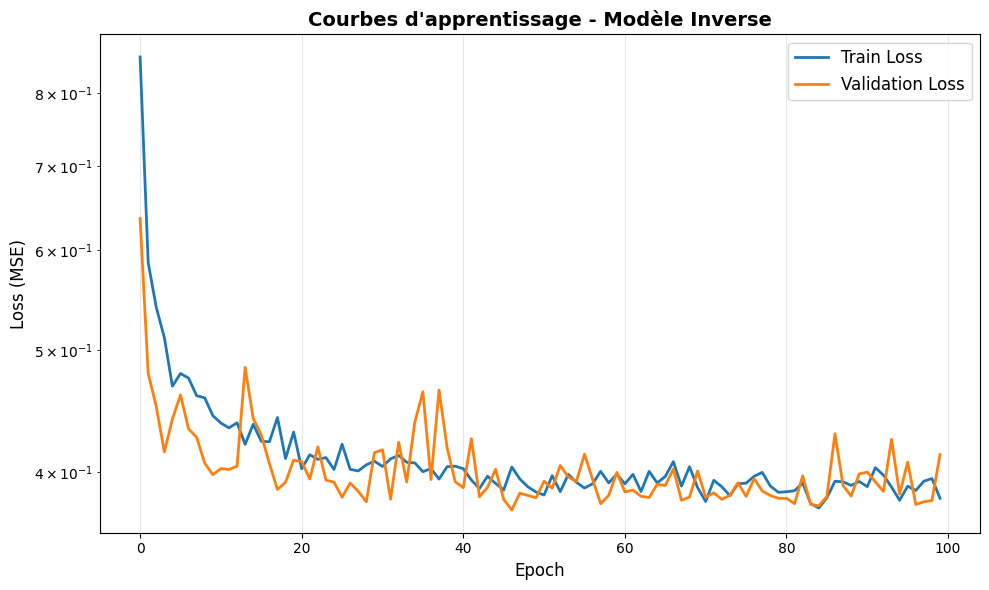

 Graphique sauvegardé : training_curves_inverse.png


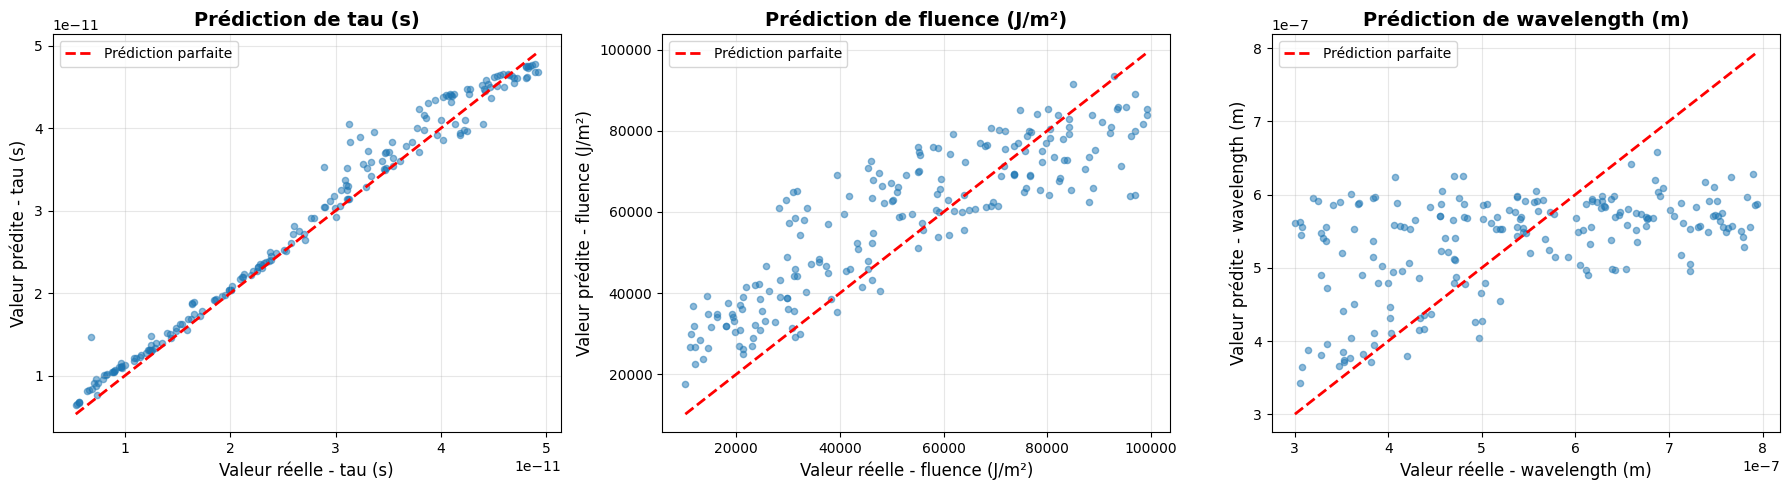


 Graphique sauvegardé : inverse_model_predictions.png


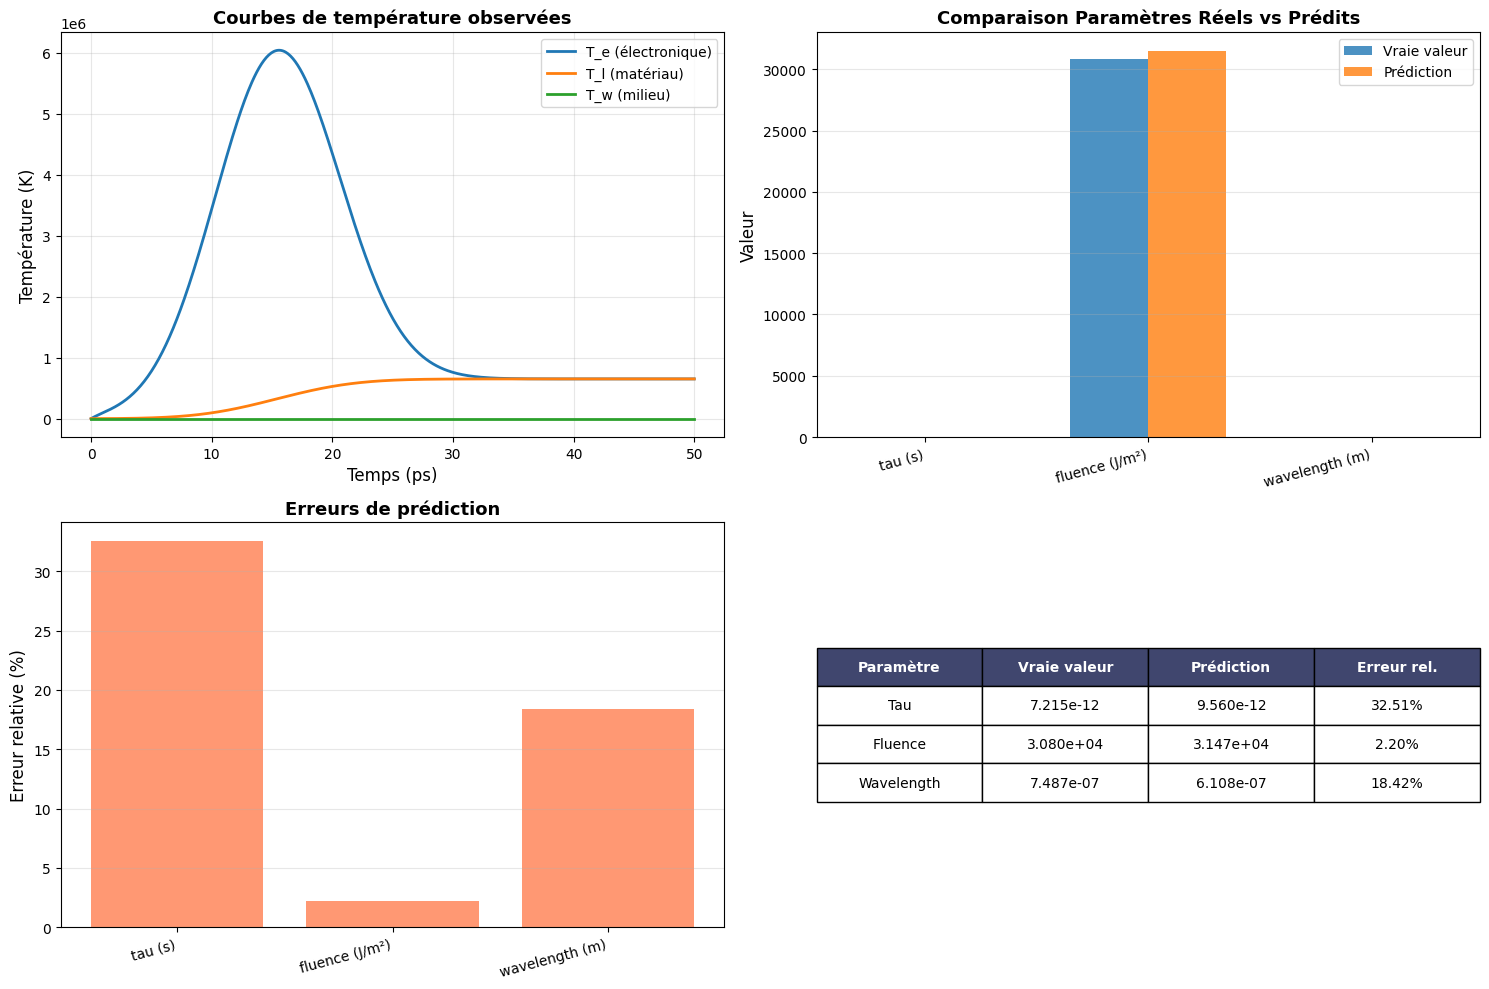


 Graphique sauvegardé : example_prediction_0.png


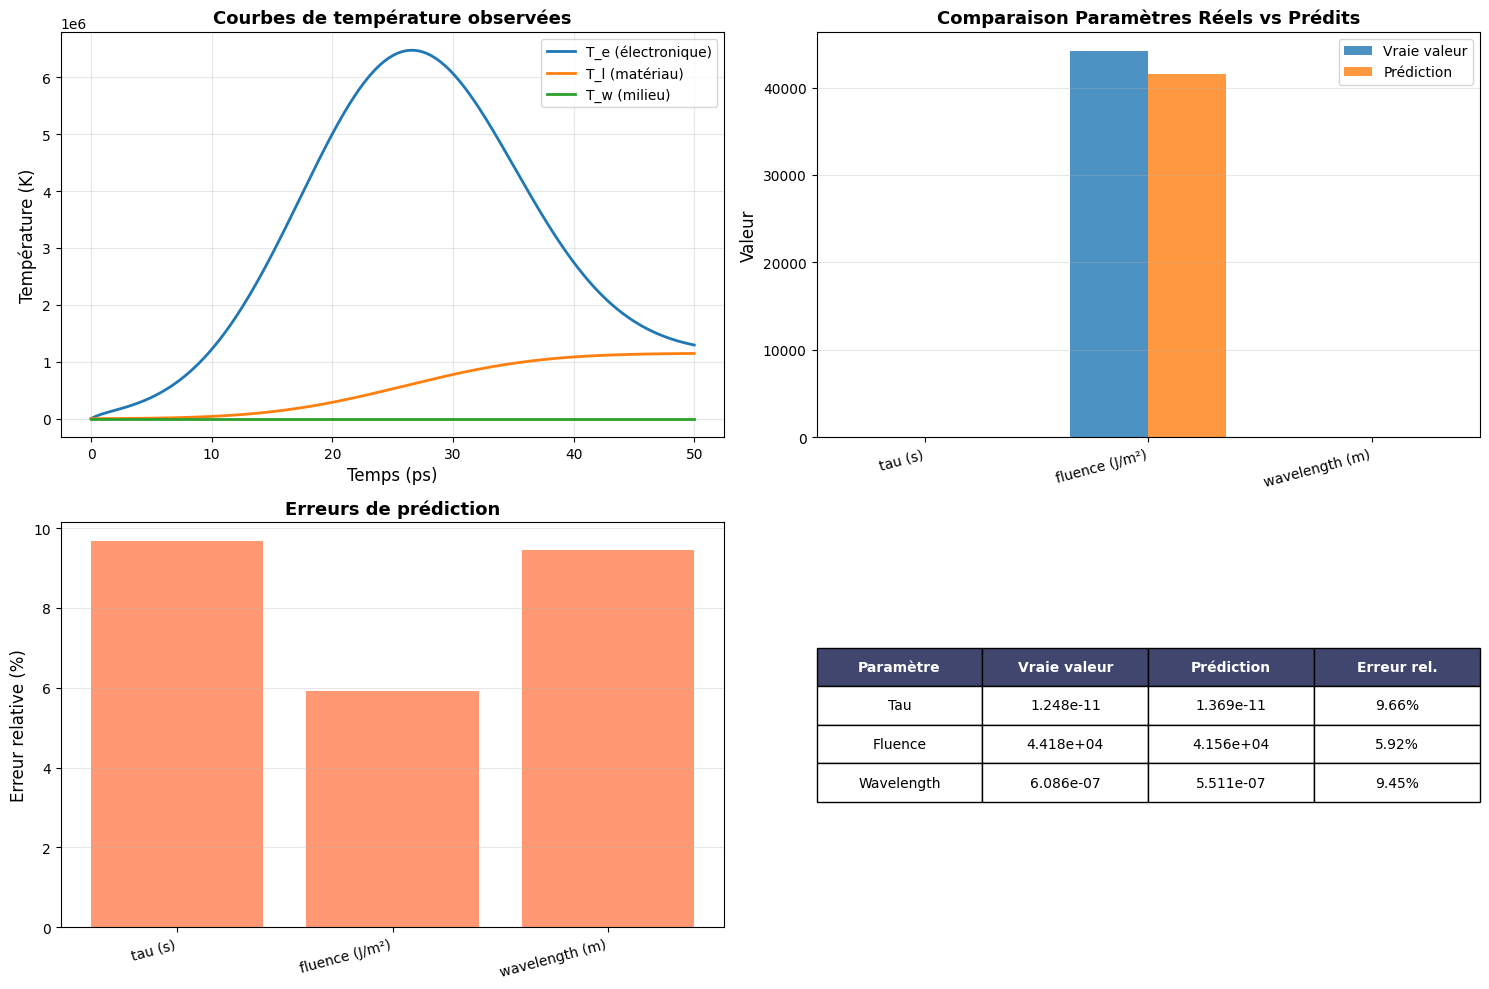


 Graphique sauvegardé : example_prediction_5.png

TÂCHE 3 TERMINÉE AVEC SUCCÈS

 Fichiers générés:
  - inverse_model_predictions.png
  - training_curves_inverse.png
  - example_prediction_0.png
  - example_prediction_5.png

 Suggestions d'amélioration:
  - Augmenter le nombre de simulations (N_SAMPLES)
  - Tester différentes architectures (CNN, LSTM)
  - Extraire des features physiques des courbes
  - Utiliser des techniques d'ensemble learning


In [79]:
if __name__ == "__main__":
    model, train_dataset, test_dataset, test_data = main()

**Modélisation Inverse des Paramètres Laser**


**Démarche**:
*  Le code résout un problème inverse : retrouver les paramètres laser (τ, fluence, λ) à partir des courbes de température observées.

**Méthode**:

*   1000 simulations du modèle à deux températures avec paramètres variés
*   Réseau de neurones profond [512, 256, 128, 64] avec dropout et batch normalization
*   Split 64/16/20% et normalisation des données
*   Entraînement sur 100 époques avec MSE loss

**Résultats attendus**:

* Convergence rapide (40-60 époques)
* Meilleure prédiction pour λ, plus difficile pour τ
* Bonne corrélation prédictions/valeurs réelles

**Conclusion**:

* Dans cette tâche, on a ou démontrer la possibilité de réaliser une modélisation inverse: à partir des seules trois températures issues du modèle, il devient possible d'inférer le temps caractéristique tau associé au processus de génération de données. Cette approche montre que les températures, habituellement vues comme des grandeurs résultantes, peuvent servir d'observables suffisantes pour reconstruire les paramètres dynamiques du système. Elle offre ainsi une voie robuste pour relier directement les mesures expérimentales aux propriétés physiques décrivant l'évolution temporelle du phénomène étudié. 